In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

In [2]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 4 GPUs.  Setting memory growth = True.


In [3]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, random_elts, elts_add_mixture_params, elts_add_H
from random_elements import best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [4]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [5]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [6]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [7]:
# Parameters to build random orbital elements and ztf_ast
random_seed = 0
known_ast = True
batch_size_init = 1024
batch_size = 64
thresh_deg = 2.0

In [8]:
# Load ztf nearest asteroid data for known asteroids
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [9]:
# Review ztf_ast
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
602,602,b'ZTF18acqvjbw',689314713015015008,16951,58443.314711,63.025354,17.655906,0.432230,0.899796,-0.059531,18.519199,1.000000,135355,3.663691e-06,63.025567,17.655961,0.432226,0.899798,-0.059531,True
649,649,b'ZTF18acrcadh',693308213515015017,17096,58447.308218,113.354357,33.962194,-0.328791,0.920837,0.209659,18.055201,1.000000,29076,8.997226e-07,113.354324,33.962150,-0.328790,0.920837,0.209658,True
811,811,b'ZTF18abwawbk',621435901715015019,9621,58375.435903,32.348343,11.149056,0.828867,0.558563,-0.031414,19.707199,1.000000,101787,2.084178e-06,32.348465,11.149059,0.828866,0.558565,-0.031414,True
833,833,b'ZTF18acurwxa',707509454415015012,18339,58461.509456,103.310341,27.540611,-0.204137,0.975586,0.080995,19.427401,1.000000,138763,4.068908e-06,103.310581,27.540515,-0.204141,0.975585,0.080994,True
890,890,b'ZTF18acuiphp',707257536115015009,18272,58461.257535,48.496514,22.452973,0.612431,0.786949,0.075091,19.038000,0.976392,105289,3.491132e-06,48.496726,22.453012,0.612428,0.786952,0.075091,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697829,5697829,b'ZTF20aarepii',1151522393415015017,97090,58905.522396,236.892710,-2.341055,-0.545753,-0.784135,0.295442,15.089800,1.000000,727,2.473898e-06,236.892569,-2.341034,-0.545755,-0.784134,0.295442,True
5697832,5697832,b'ZTF20aareowa',1151522390315015003,97090,58905.522396,237.654792,-5.909325,-0.532176,-0.811960,0.239813,15.717300,1.000000,625,2.355026e-06,237.654657,-5.909328,-0.532178,-0.811958,0.239813,True
5697833,5697833,b'ZTF20aareowm',1151521944715015006,97089,58905.521944,236.239354,-9.304550,-0.548413,-0.817041,0.178007,15.695800,1.000000,464,2.205903e-06,236.239228,-9.304526,-0.548415,-0.817040,0.178007,True
5697838,5697838,b'ZTF20aareowf',1151521946215015005,97089,58905.521944,234.674482,-7.771349,-0.572910,-0.795468,0.197496,16.917900,1.000000,2879,4.163074e-06,234.674242,-7.771368,-0.572914,-0.795466,0.197494,True


In [10]:
# Best random elements
elts = best_random_elts(random_seed=random_seed, known_ast=known_ast, 
                        batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [11]:
# Review best random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273
...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778


## Batches of ZTF Data Near Initial Candidate Elements

In [12]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [13]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [14]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,357652,0,b'ZTF19abjggig',938492372315015003,1268,58692.492373,53.778435,17.745455,0.562794,0.826188,...,0.554305,0.832313,-0.001318,3.030342,0.026805,5529.148243,0.999641,0.589752,False,False
1,358253,0,b'ZTF19abjgfhg',938492373915015003,1268,58692.492373,53.995882,19.505049,0.554108,0.832439,...,0.554305,0.832313,-0.001318,3.030342,0.004338,894.747682,0.999991,0.015445,False,False
2,359127,0,b'ZTF19abjgfhd',938492373915015019,1268,58692.492373,53.303148,19.154581,0.564497,0.825435,...,0.554305,0.832313,-0.001318,3.030342,0.012343,2545.891323,0.999924,0.125041,False,False
3,359244,0,b'ZTF19abjgfqh',938492373315015008,1268,58692.492373,54.457412,20.235852,0.545428,0.838047,...,0.554305,0.832313,-0.001318,3.030342,0.018328,3780.523027,0.999832,0.275722,False,False
4,359275,0,b'ZTF19abjgfjl',938492371615015001,1268,58692.492373,55.224952,18.713324,0.540204,0.841398,...,0.554305,0.832313,-0.001318,3.030342,0.021711,4478.268990,0.999764,0.386885,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512300,5682027,63,b'ZTF20aarbsoy',1151130435015015008,39108,58905.130440,46.250023,14.103319,0.670669,0.739706,...,0.660978,0.749074,-0.044681,2.592171,0.017045,3515.894844,0.999855,0.238474,False,False
512301,5682059,63,b'ZTF20aarbsvt',1151130433215015003,39108,58905.130440,46.974922,12.957800,0.664943,0.742845,...,0.660978,0.749074,-0.044681,2.592171,0.033797,6971.539164,0.999429,0.937551,False,False
512302,5682122,63,b'ZTF20aarbsrh',1151130435215015007,39108,58905.130440,44.917822,15.212759,0.683306,0.729504,...,0.660978,0.749074,-0.044681,2.592171,0.033002,6807.415135,0.999455,0.893931,False,False
512303,5682133,63,b'ZTF20aarbsrx',1151130434815015006,39108,58905.130440,47.131113,15.156325,0.656659,0.753044,...,0.660978,0.749074,-0.044681,2.592171,0.006666,1374.963549,0.999978,0.036472,False,False


In [15]:
# Score by element
score_by_elt = ztf_score_by_elt(ztf_elt)

In [16]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [17]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, thresh_deg=thresh_deg, R_deg=R_deg)

In [18]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [19]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :   512305   (     8005)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     442.59
Sqrt(batch_obs):      89.47
Mean t_score   :       5.11


In [20]:
# Review random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score,num_hits,R,thresh_s,H,sigma_mag
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007,10,0.008727,0.034905,16.5,4.0
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007,10,0.008727,0.034905,16.5,4.0
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071,10,0.008727,0.034905,16.5,4.0
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322,10,0.008727,0.034905,16.5,4.0
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314,10,0.008727,0.034905,16.5,4.0
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832,10,0.008727,0.034905,16.5,4.0
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432,10,0.008727,0.034905,16.5,4.0
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [21]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [22]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [23]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [24]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     1.44  :   0.00 :  1793.72 :  7200.00
Mean     :     1.44  :   0.00 :  1793.72 :  7200.00
Median   :     1.31  :   0.00 :  1792.82 :  7200.00
GeoMean  :     1.40  :   0.00 :  1793.71 :  7200.99
Min      :     0.42  :   0.00 :  1792.82 :  7200.00
Max      :     3.65  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


## Automated Training with Sieve Method


********************************************************************************
Round 1: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 3200 samples
Epoch 1/4
3200/3200 [==============================] - 3s 940us/sample - loss: -75258.2337
Epoch 2/4
3200/3200 [==============================] - 1s 464us/sample - loss: -85694.5411
Epoch 3/4
3200/3200 [==============================] - 1s 457us/sample - loss: -97367.5564
Epoch 4/4
3200/3200 [==============================] - 1s 461us/sample - loss: -110584.1034
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1318.49 :  1318.49 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      2.41 :     2.41 :      nan
Mean Hits           :      0.0

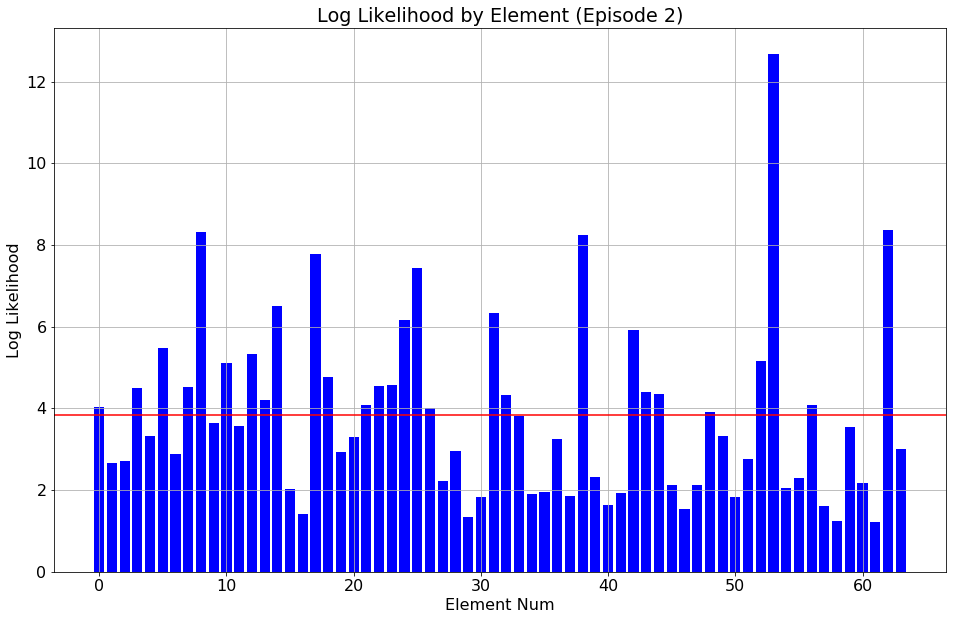

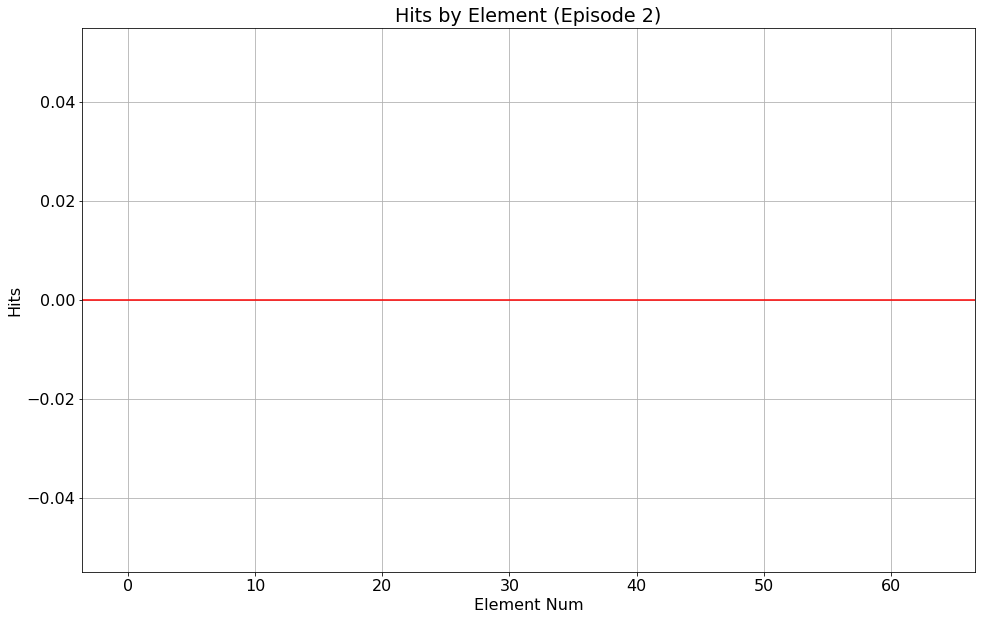


********************************************************************************
Round 2: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 2: Epoch    8, Batch    400
effective_learning_rate=1.526e-05, training_time 20 sec.
Train on 3200 samples
Epoch 9/12
3200/3200 [==============================] - 4s 1ms/sample - loss: -354310.4438
Epoch 10/12
3200/3200 [==============================] - 2s 602us/sample - loss: -423818.8400
Epoch 11/12
3200/3200 [==============================] - 2s 599us/sample - loss: -459702.7056
Epoch 12/12
3200/3200 [==============================] - 2s 599us/sample - loss: -492668.8687
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1024.48 :  1024.48 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :     10.31 :

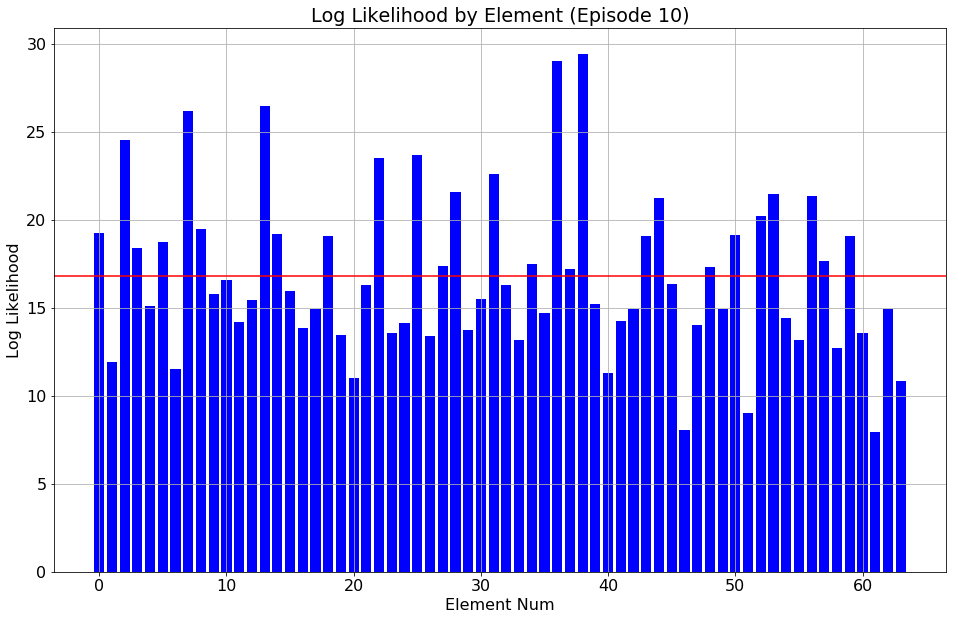

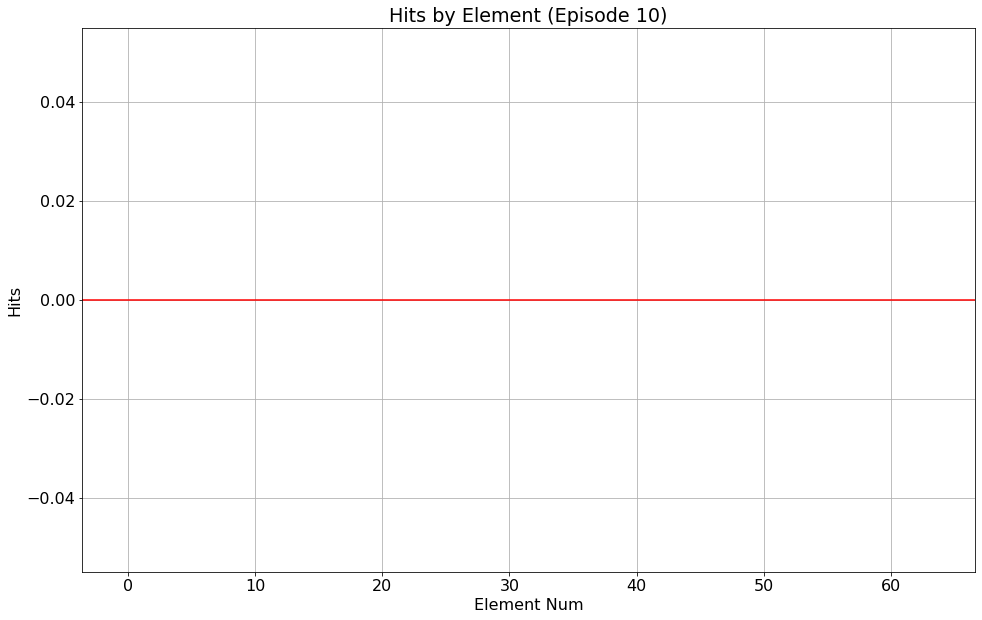


********************************************************************************
Round 3: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2000
effective_learning_rate=1.526e-05, training_time 95 sec.
Train on 3200 samples
Epoch 41/44
3200/3200 [==============================] - 3s 1ms/sample - loss: -983220.6500
Epoch 42/44
3200/3200 [==============================] - 2s 477us/sample - loss: -1119254.9375
Epoch 43/44
3200/3200 [==============================] - 2s 476us/sample - loss: -1260971.2550
Epoch 44/44
3200/3200 [==============================] - 2s 476us/sample - loss: -1404683.9400
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    586.66 :   586.66 :      nan arc seconds
Geom Mean Threshold :   5400.00 :  5400.00 :      nan arc seconds
Mean Log Likelihood :     17.13 :    17.13 :      nan
Mean Hits       

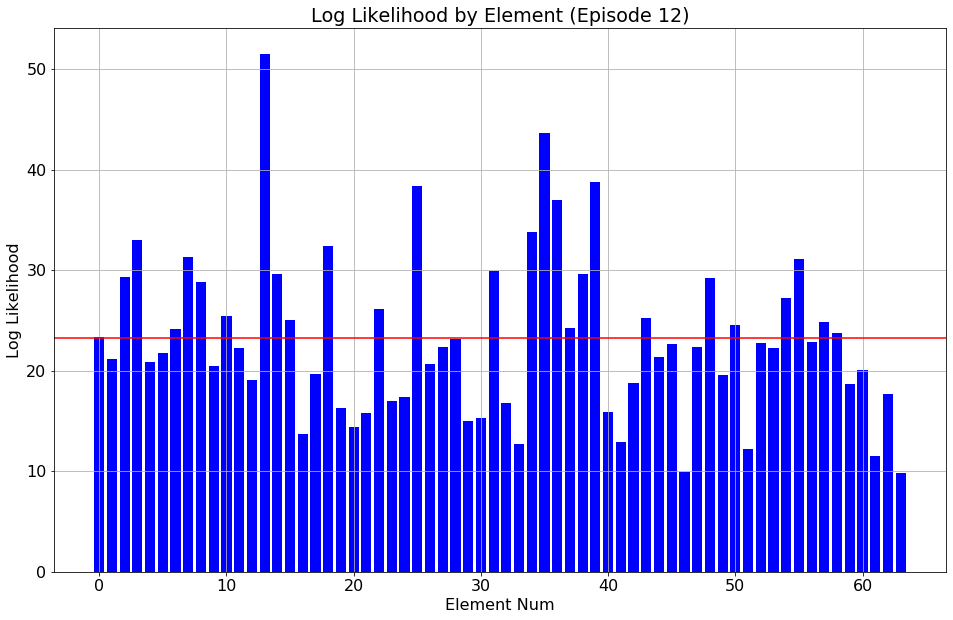

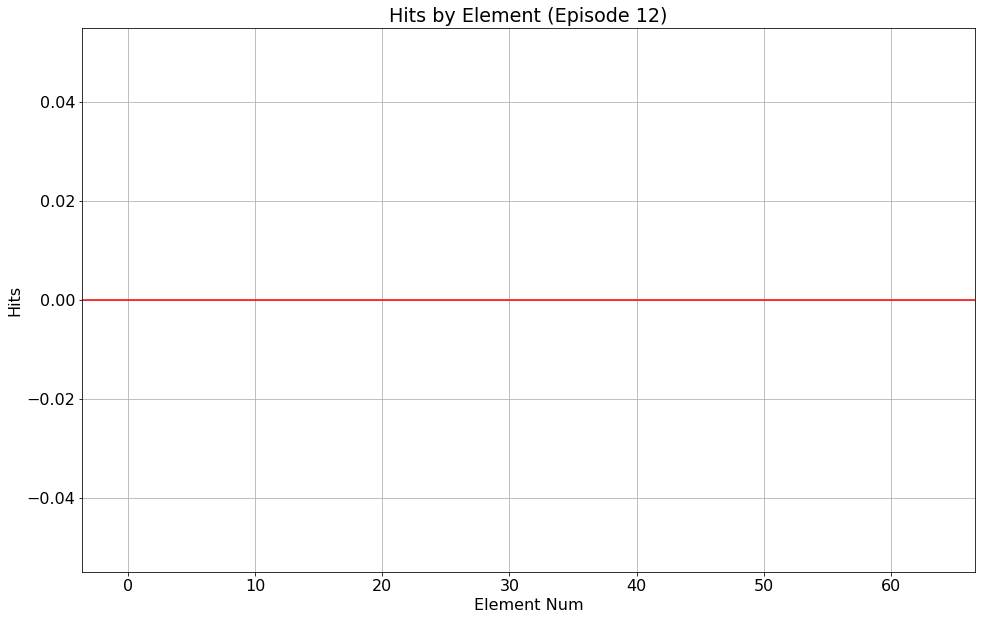


********************************************************************************
Round 4: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 12: Epoch   48, Batch   2400
effective_learning_rate=1.526e-05, training_time 112 sec.
Train on 3200 samples
Epoch 49/52
3200/3200 [==============================] - 4s 1ms/sample - loss: -2107878.0900
Epoch 50/52
3200/3200 [==============================] - 2s 623us/sample - loss: -2165863.1050
Epoch 51/52
3200/3200 [==============================] - 2s 610us/sample - loss: -2204685.5800
Epoch 52/52
3200/3200 [==============================] - 2s 614us/sample - loss: -2240159.9300
Adjusted element weight down on 1 candidate elements. Mean weight = 9.92e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    471.07 :   471.07 :      nan arc seconds
Geom Mean Thres

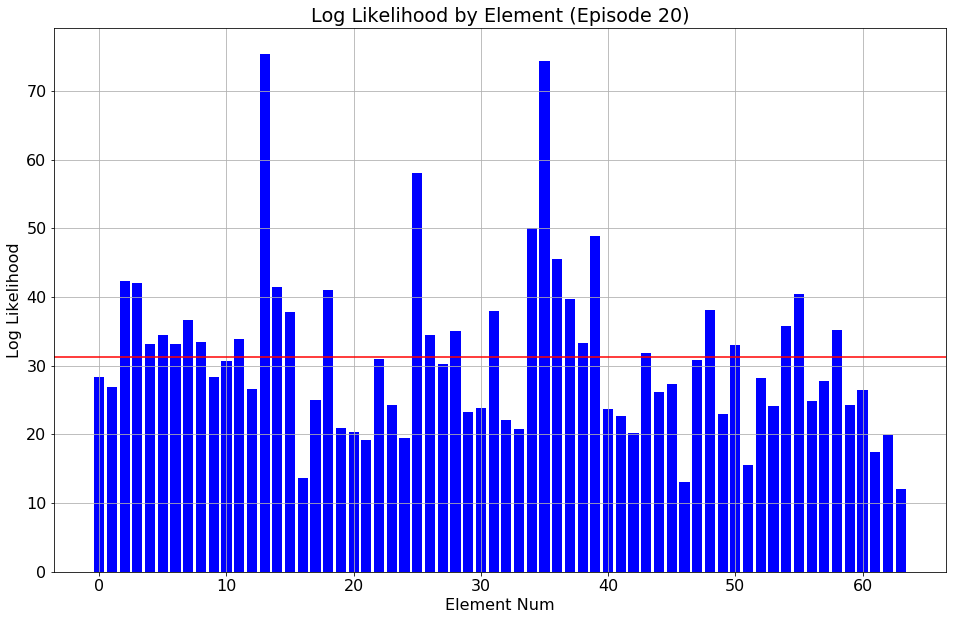

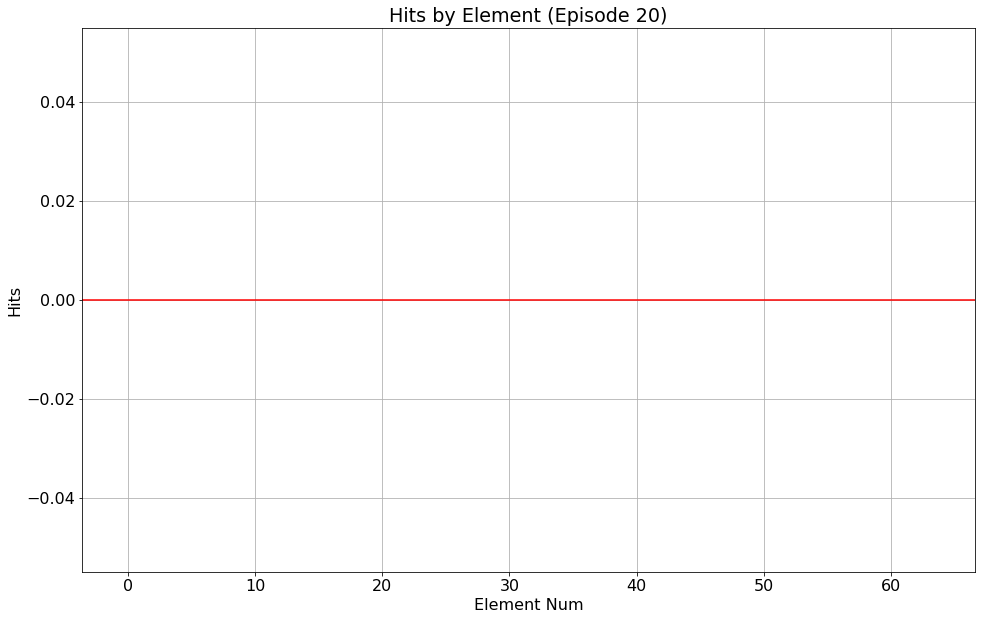


********************************************************************************
Round 5: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 20: Epoch   80, Batch   4000
effective_learning_rate=1.878e-06, training_time 191 sec.
Train on 3200 samples
Epoch 81/84
3200/3200 [==============================] - 3s 968us/sample - loss: -5086373.9200
Epoch 82/84
3200/3200 [==============================] - 2s 543us/sample - loss: -5467076.8300
Epoch 83/84
3200/3200 [==============================] - 2s 563us/sample - loss: -5802262.3500
Epoch 84/84
3200/3200 [==============================] - 2s 540us/sample - loss: -6117308.3100
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    349.76 :   349.76 :      nan arc seconds
Geom Mean Threshold :   3593.83 :  3593.83 :      nan arc seconds
Mean Log Likelihood :     32.34 :    32.34 :      nan
Mean Hits   

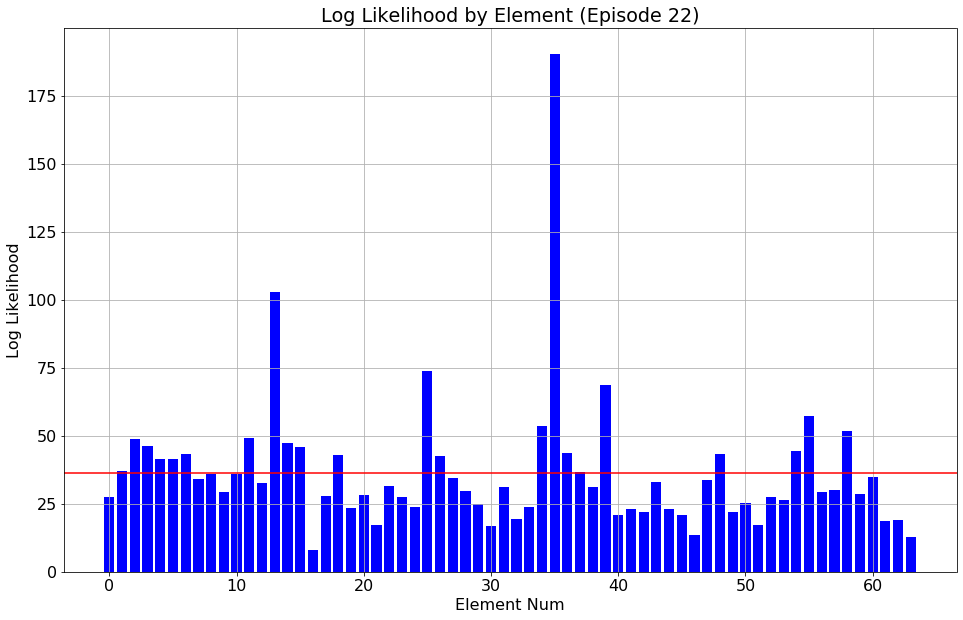

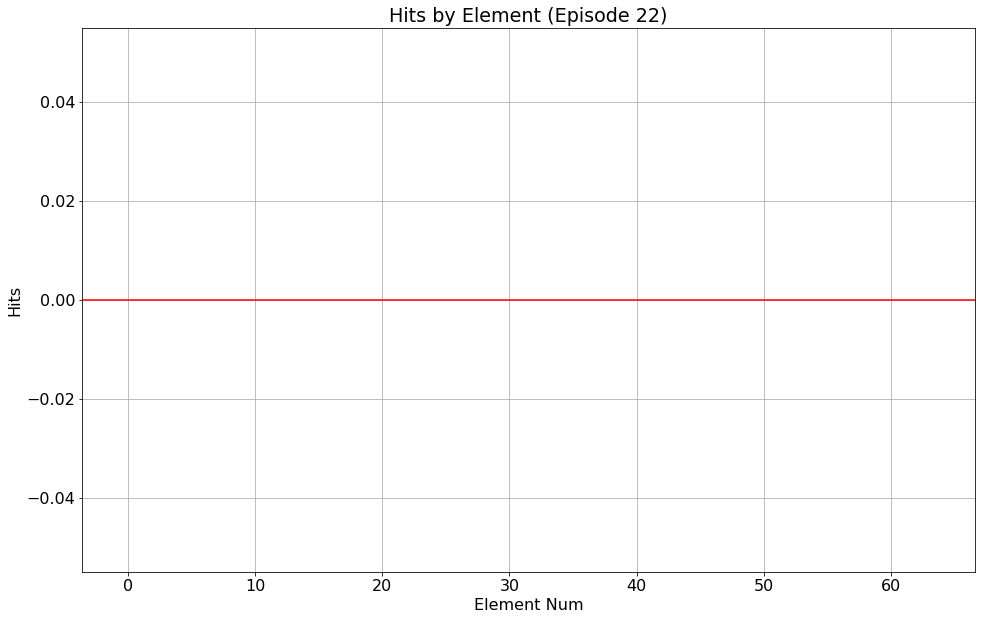


********************************************************************************
Round 6: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 22: Epoch   88, Batch   4400
effective_learning_rate=2.422e-04, training_time 209 sec.
Train on 3200 samples
Epoch 89/92
3200/3200 [==============================] - 4s 1ms/sample - loss: -9674048.5000
Epoch 90/92
3200/3200 [==============================] - 2s 647us/sample - loss: -9869178.8800
Epoch 91/92
3200/3200 [==============================] - 2s 659us/sample - loss: -9993755.2400
Epoch 92/92
3200/3200 [==============================] - 2s 652us/sample - loss: -10101556.0800
Adjusted element weight down on 1 candidate elements. Mean weight = 1.22e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    339.81 :   339.81 :      nan arc seconds
Geom Mean Thre

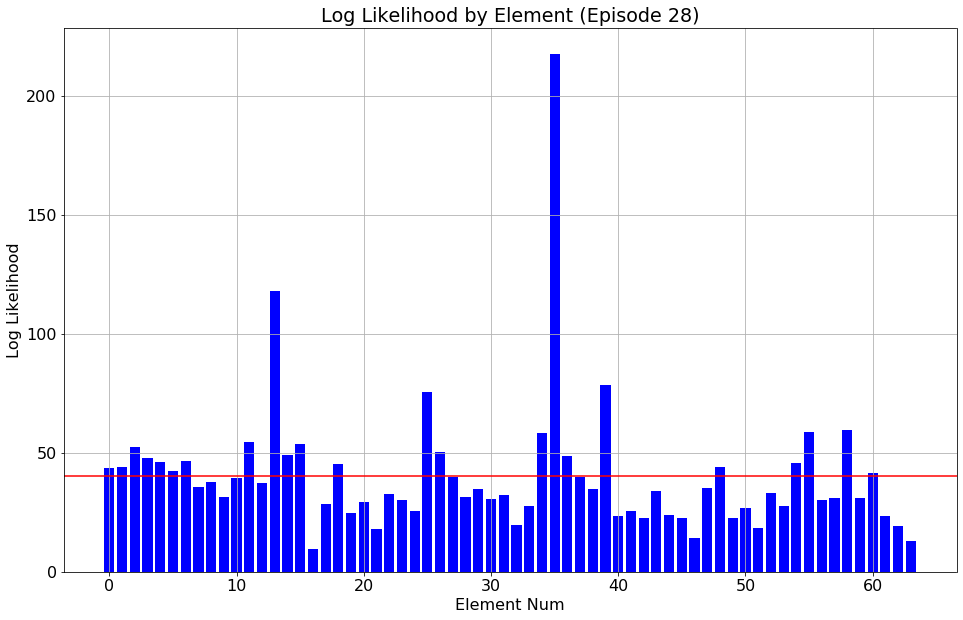

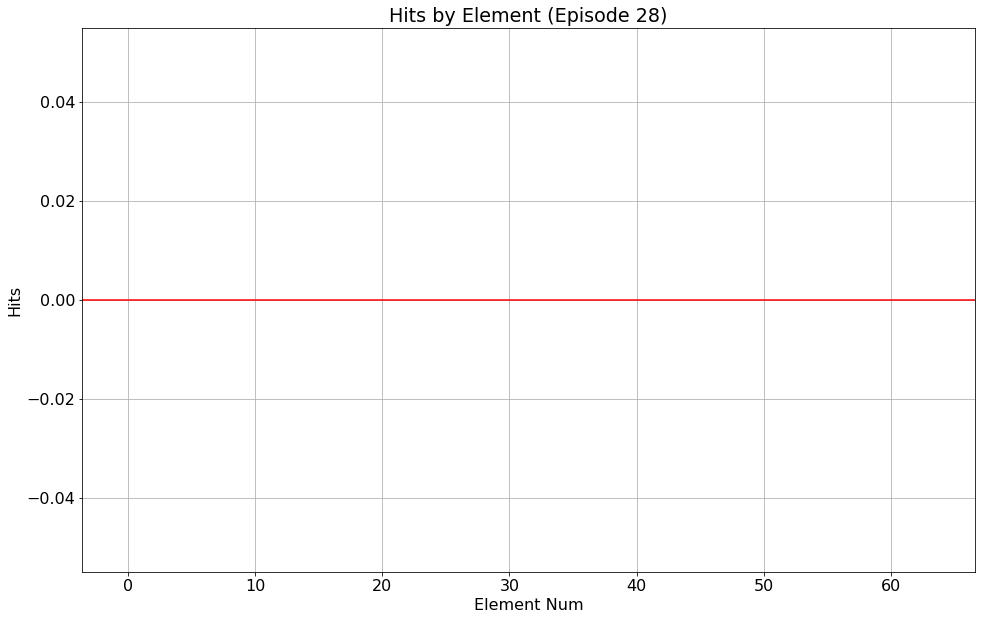


********************************************************************************
Round 7: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3000.0
********************************************************************************

Training episode 28: Epoch  112, Batch   5600
effective_learning_rate=2.441e-04, training_time 271 sec.
Train on 3200 samples
Epoch 113/116
3200/3200 [==============================] - 3s 995us/sample - loss: -13916718.2200
Epoch 114/116
3200/3200 [==============================] - 2s 571us/sample - loss: -15168906.7200
Epoch 115/116
3200/3200 [==============================] - 2s 592us/sample - loss: -16693945.7800
Epoch 116/116
3200/3200 [==============================] - 2s 574us/sample - loss: -18628067.9600
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    330.71 :   330.71 :      nan arc seconds
Geom Mean Threshold :   2903.27 :  2903.27 :      nan arc seconds
Mean Log Likelihood :     40.80 :    40.80 :      nan


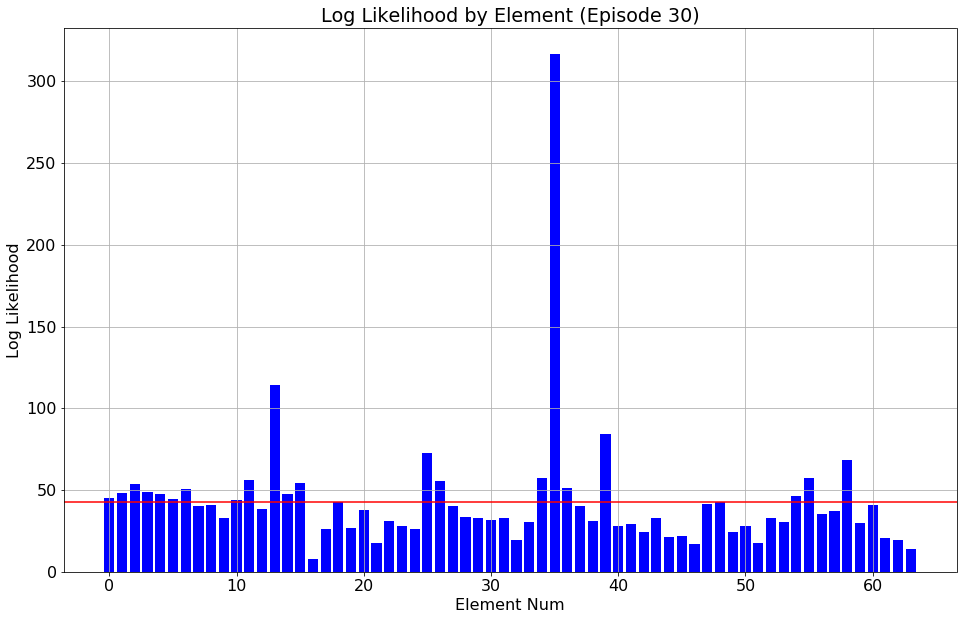

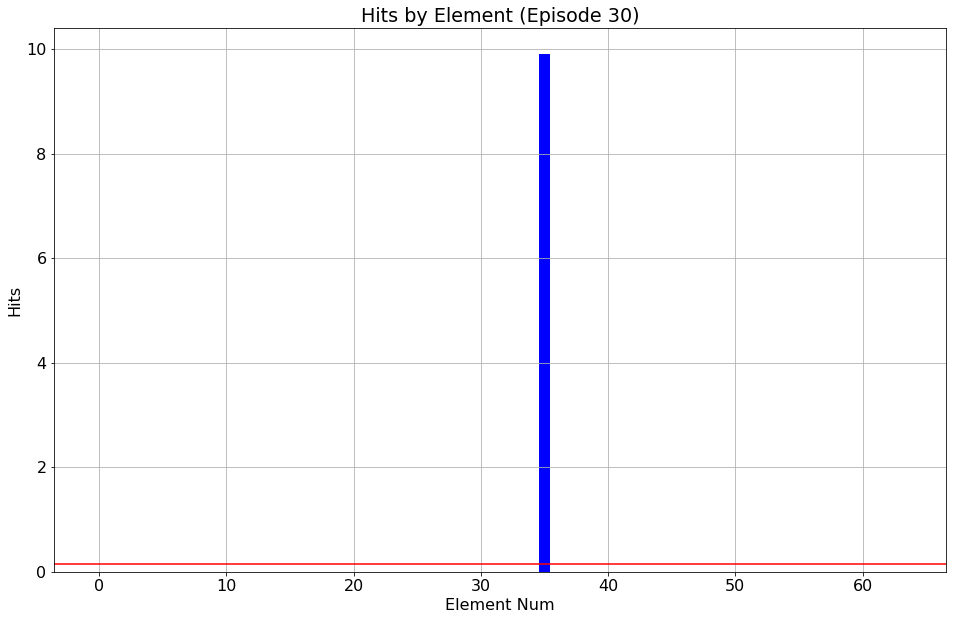


********************************************************************************
Round 8: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 30: Epoch  120, Batch   6000
effective_learning_rate=1.526e-05, training_time 290 sec.
Train on 3200 samples
Epoch 121/124
3200/3200 [==============================] - 5s 1ms/sample - loss: -39299800.2000
Epoch 122/124
3200/3200 [==============================] - 2s 671us/sample - loss: -41179622.4800
Epoch 123/124
3200/3200 [==============================] - 2s 682us/sample - loss: -41580442.0000
Epoch 124/124
3200/3200 [==============================] - 2s 676us/sample - loss: -41943722.0800
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    345.85 :

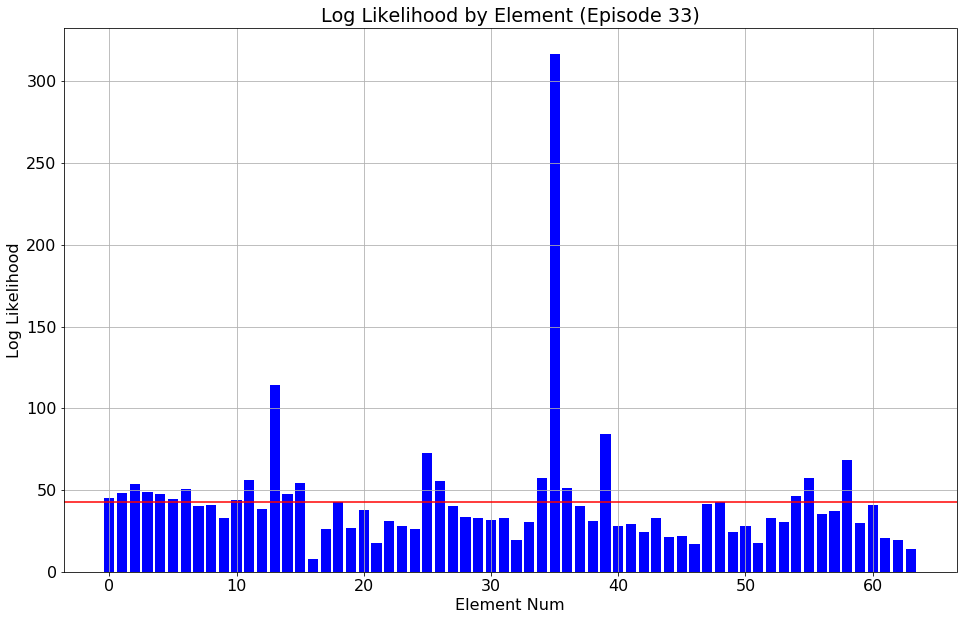

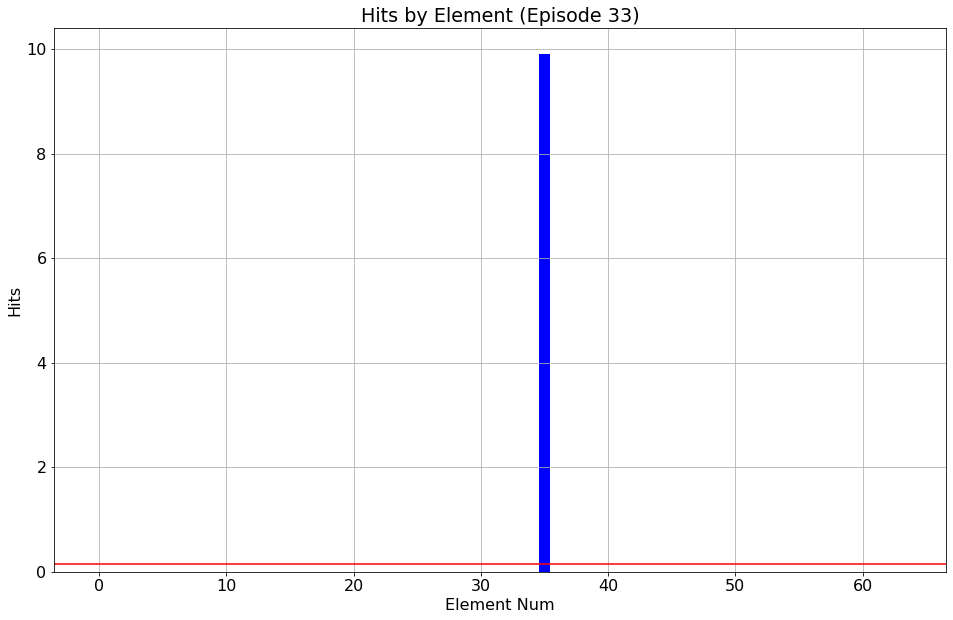


********************************************************************************
Round 9: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 33: Epoch  132, Batch   6600
effective_learning_rate=1.907e-06, training_time 323 sec.
Train on 3200 samples
Epoch 133/136
3200/3200 [==============================] - 3s 1ms/sample - loss: -46181858.0800
Epoch 134/136
3200/3200 [==============================] - 2s 606us/sample - loss: -51301408.3200
Epoch 135/136
3200/3200 [==============================] - 2s 597us/sample - loss: -57749695.6000
Epoch 136/136
3200/3200 [==============================] - 2s 601us/sample - loss: -66029729.8400
Adjusted element weight down on 2 candidate elements. Mean weight = 9.73e-01
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    368.65 :   383.29 :    31.72 arc seconds
Geom Mean Threshold :   2290.51 :  2345.34 : 

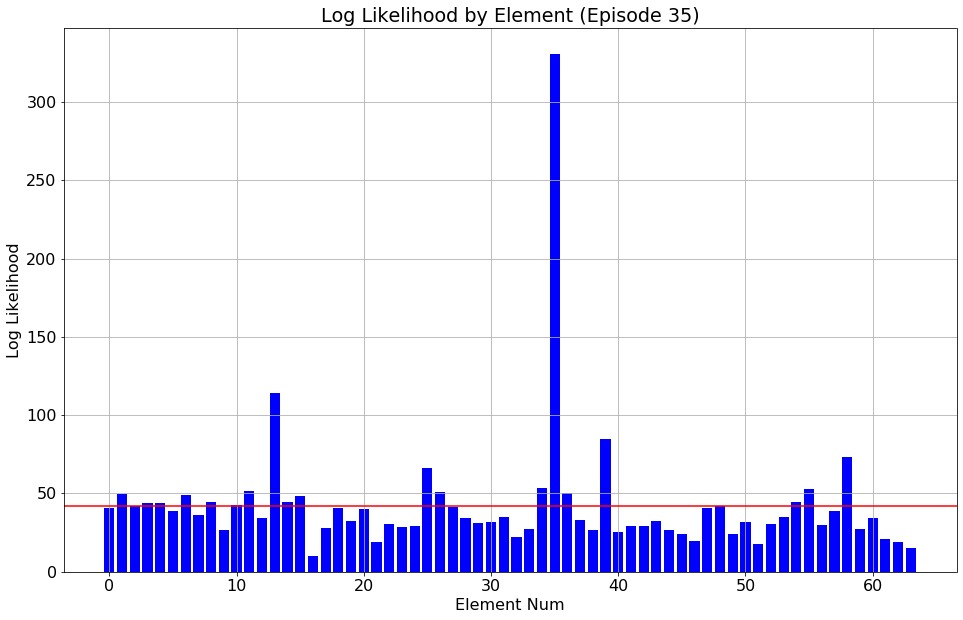

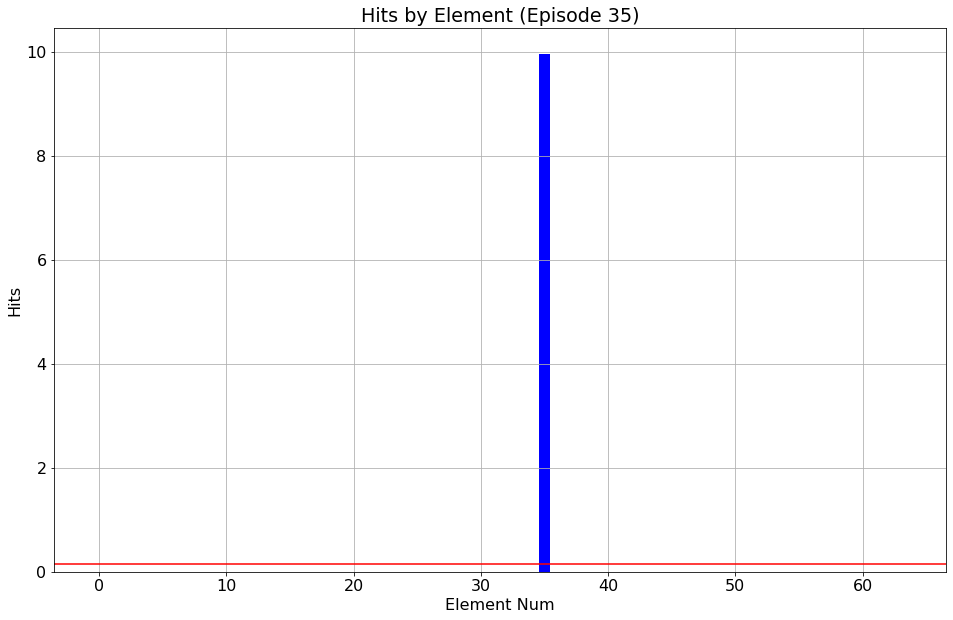


********************************************************************************
Round 10: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 35: Epoch  140, Batch   7000
effective_learning_rate=2.065e-04, training_time 343 sec.
Train on 3200 samples
Epoch 141/144
3200/3200 [==============================] - 5s 2ms/sample - loss: -38942713.1600
Epoch 142/144
3200/3200 [==============================] - 2s 735us/sample - loss: -41314729.9200
Epoch 143/144
3200/3200 [==============================] - 2s 734us/sample - loss: -41664897.9200
Epoch 144/144
3200/3200 [==============================] - 2s 718us/sample - loss: -42168238.8800
Adjusted element weight down on 64 candidate elements. Mean weight = 6.25e-02
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    392.71 

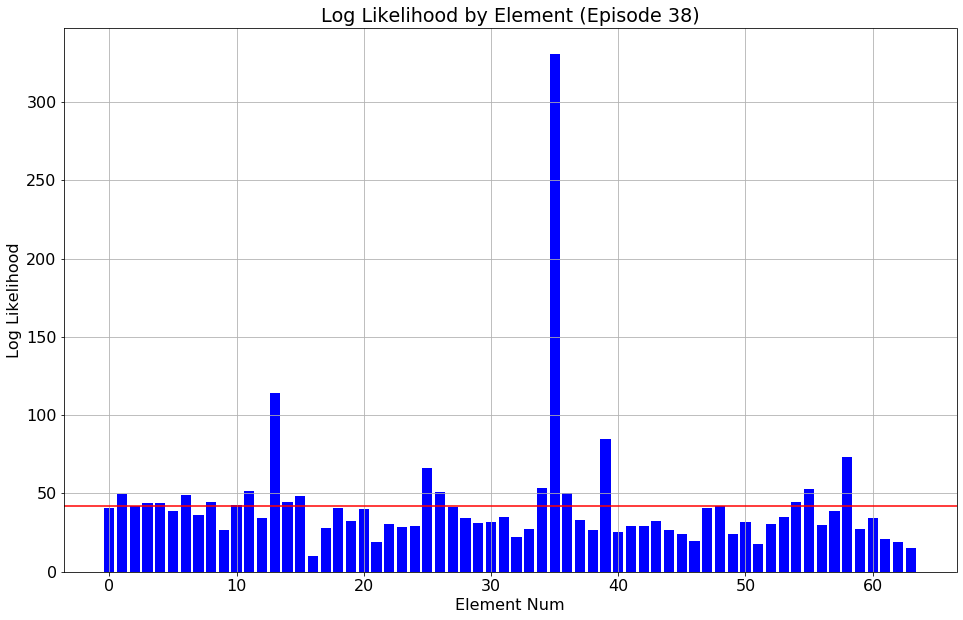

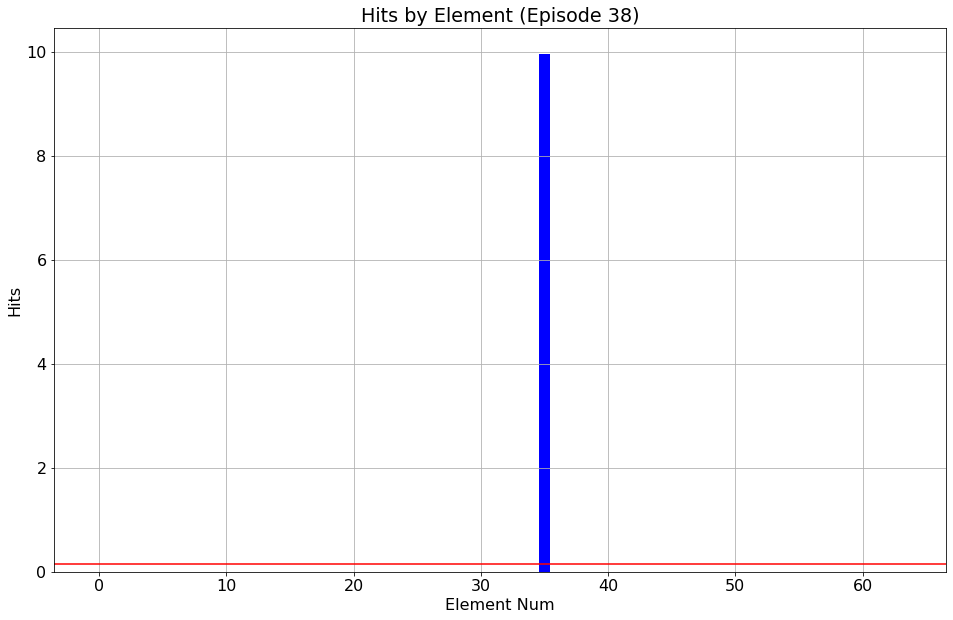


********************************************************************************
Round 11: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 1800.0
********************************************************************************

********************************************************************************
Terminating: Effective Learning Rate 2.384e-07 <= minimum 9.537e-07.
********************************************************************************

Good elements (hits >= 10):   1.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   330.53  :  10.00 :    31.72 :   516.04
Mean Bad :    33.51  :   0.00 :   477.56 :  1782.71
Mean     :    38.15  :   0.16 :   470.59 :  1762.92
Median   :    30.53  :   0.00 :   366.26 :  1800.00
GeoMean  :    31.86  :   0.04 :   381.53 :  1741.25
Min      :     5.99  :   0.00 :    31.72 :   516.04
Max      :   330.53  :  10.00 :   900.00 :  1800.00
Trained for 7600 batches over 152 epochs and 38 episodes (elapsed time 377 s

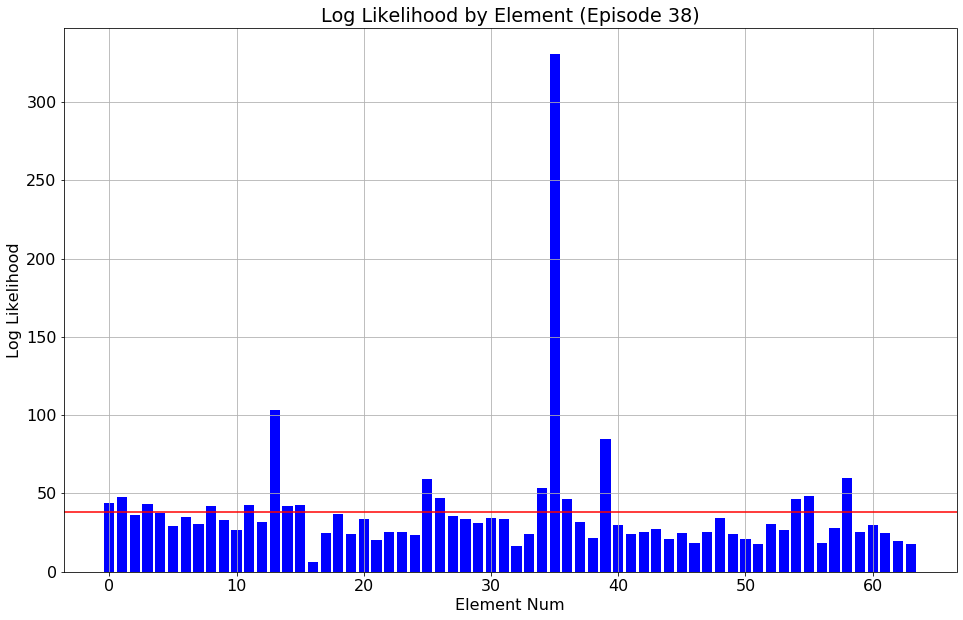

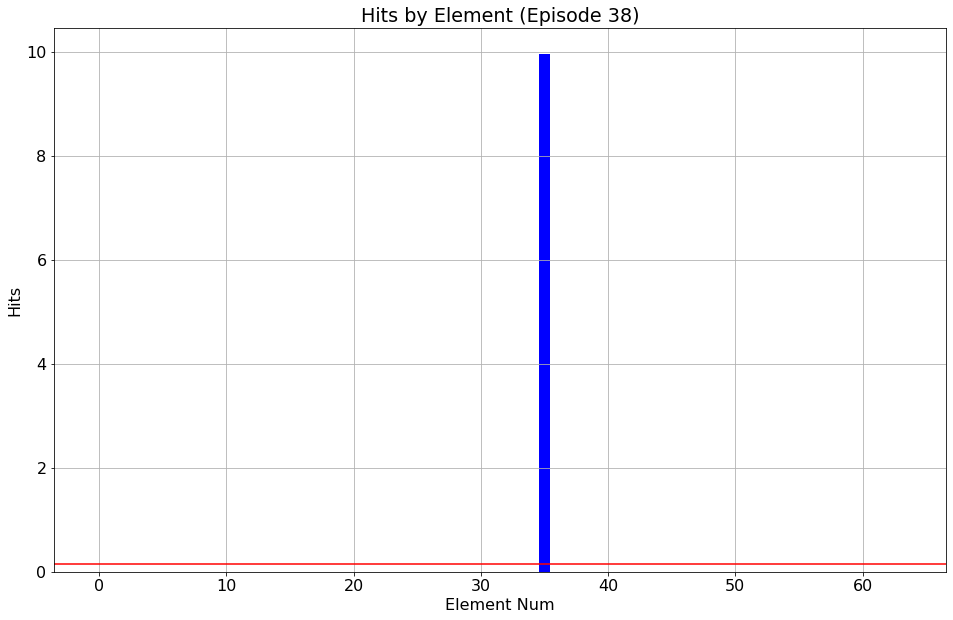


********************************************************************************
Round 12: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 38: Epoch  152, Batch   7600
effective_learning_rate=2.384e-07, training_time 377 sec.
Train on 3200 samples
Epoch 153/156
3200/3200 [==============================] - 5s 1ms/sample - loss: -45706568.8800
Epoch 154/156
3200/3200 [==============================] - 2s 739us/sample - loss: -48188922.0800
Epoch 155/156
3200/3200 [==============================] - 2s 741us/sample - loss: -48617210.2400
Epoch 156/156
3200/3200 [==============================] - 2s 734us/sample - loss: -49099740.1600
Adjusted element weight down on 64 candidate elements. Mean weight = 7.81e-03
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    381.15 

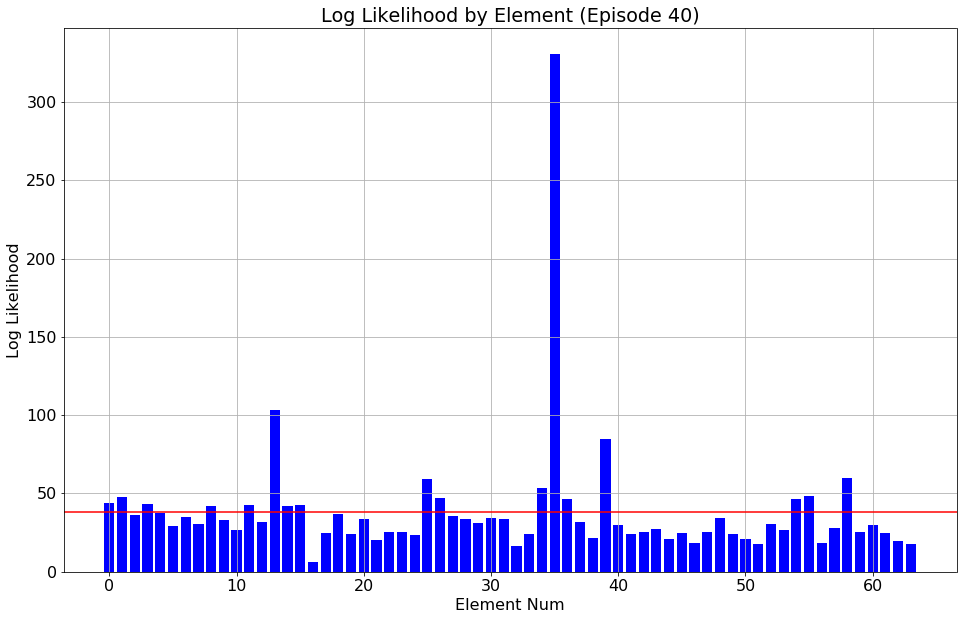

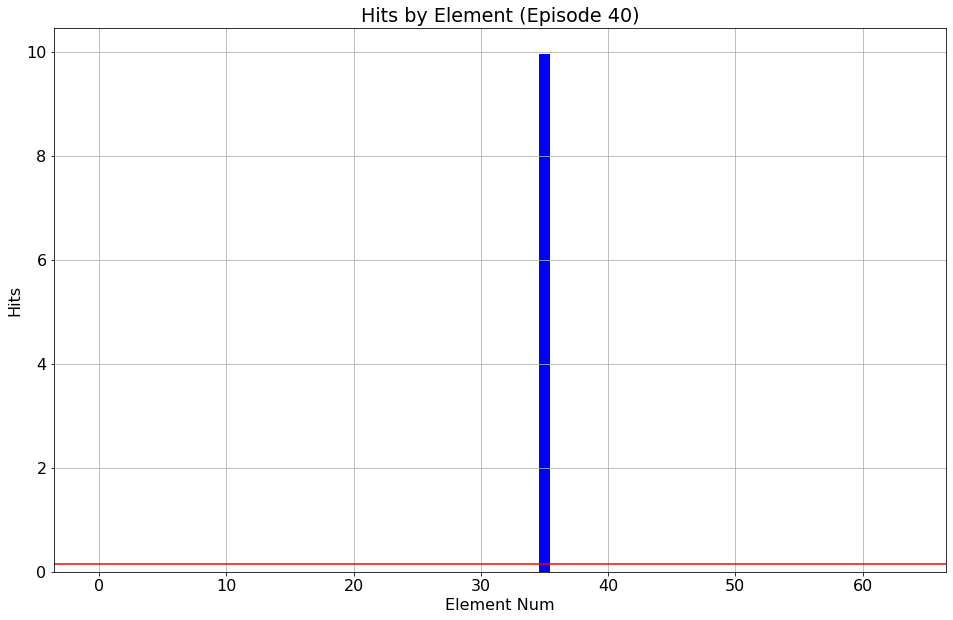


********************************************************************************
Round 7: 1000 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 400.0
********************************************************************************

Training episode 40: Epoch  160, Batch   8000
effective_learning_rate=2.441e-04, training_time 404 sec.
Train on 3200 samples
Epoch 161/164
3200/3200 [==============================] - 3s 1ms/sample - loss: -104987854.2400
Epoch 162/164
3200/3200 [==============================] - 2s 610us/sample - loss: -114119510.2400
Epoch 163/164
3200/3200 [==============================] - 2s 624us/sample - loss: -123680565.9200
Epoch 164/164
3200/3200 [==============================] - 2s 628us/sample - loss: -132527594.4000
Adjusted element weight down on 20 candidate elements. Mean weight = 8.44e-01
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    184.45 :   189.68 :    31.72 arc seconds
Geom Mean Threshold :    400.00 :   400.

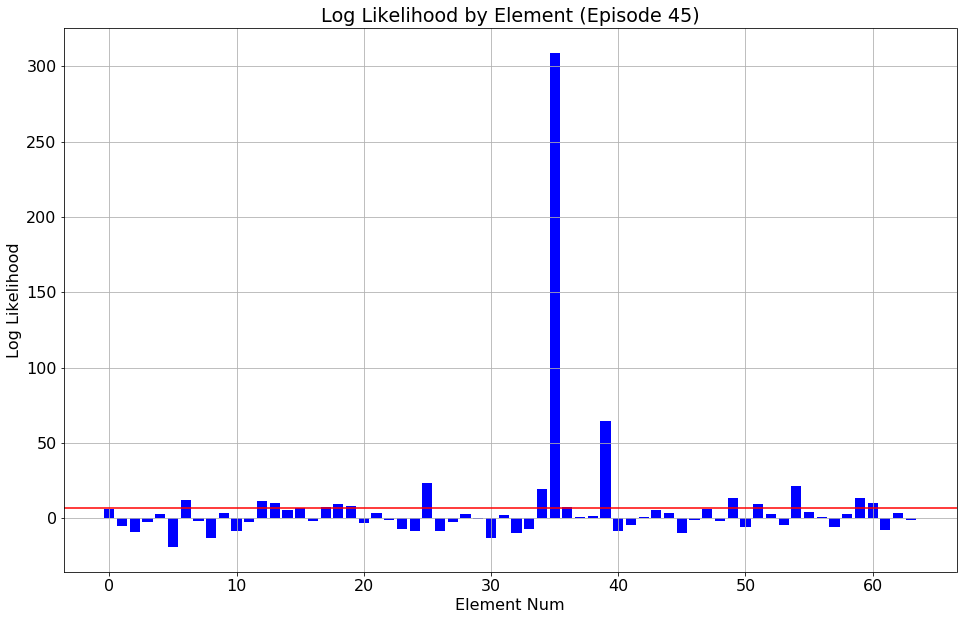

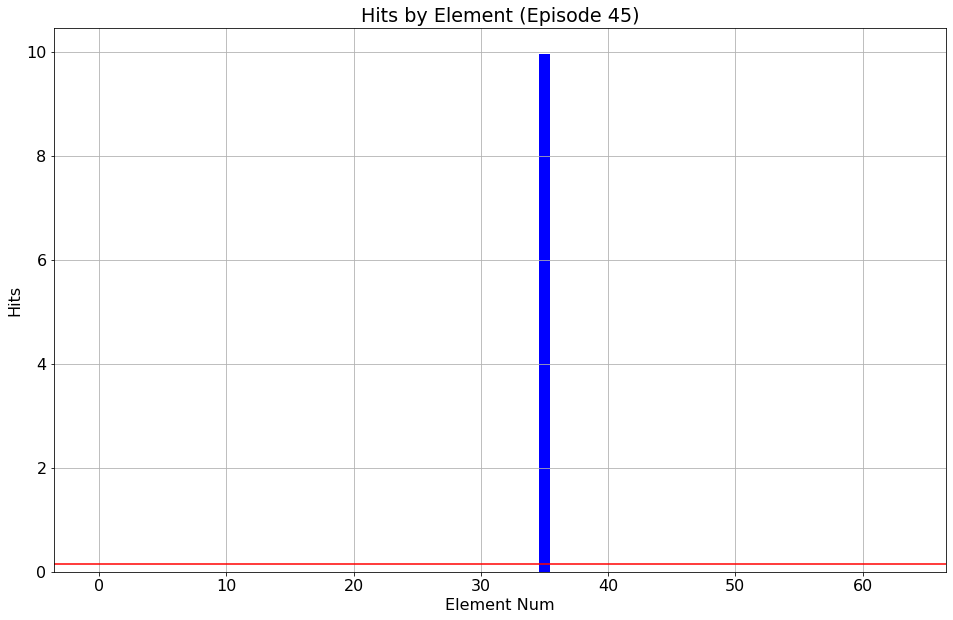


********************************************************************************
Round 8: 4000 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 45: Epoch  180, Batch   9000
effective_learning_rate=3.815e-06, training_time 448 sec.
Train on 3200 samples
Epoch 181/184
3200/3200 [==============================] - 5s 2ms/sample - loss: -43352099.3600
Epoch 182/184
3200/3200 [==============================] - 2s 772us/sample - loss: -49773710.4000
Epoch 183/184
3200/3200 [==============================] - 2s 768us/sample - loss: -52267513.0400
Epoch 184/184
3200/3200 [==============================] - 2s 760us/sample - loss: -53552909.6800
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    181.22 :

In [ ]:
model.sieve(nearest_ast=True)

## Review Results Graphically

In [ ]:
# # Bar chart - log likelihood by element
# fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# # Bar chart: hits
# fig, ax = model.plot_bar('hits', sorted=False)

In [ ]:
# # Bar chart: log likelihood
# fig, ax = model.plot_bar('R_deg', sorted=False)

In [ ]:
# # Learning curve: log likelihood
# fig, ax = model.plot_hist('log_like')

In [ ]:
# # Learning curve: hits
# fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [ ]:
# Find nearest asteroid to fitted elements - search on Cartesian distance
elts_fit, elts_near = model.nearest_ast(search_type='cart')

In [ ]:
elts_fit

In [ ]:
# Review asteroids nearest to the fitted elements
# cols = ['element_id', 'nearest_ast_num', 'nearest_ast_name', 'nearest_ast_dist', 'nearest_ast_q_norm']
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
is_close_cart = (model.elts_near_ast.nearest_ast_dist < 5.0E-3)
is_close_cov = (model.elts_near_ast.nearest_ast_q_norm < 1.0)
has_hits = (np.round(model.elts_fit.hits) >= 10)
# is_converged = is_close_cart & is_close_cov
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits)
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.mean(model.elts_near_ast.nearest_ast_q_norm[is_converged])

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm: {err_cov_mean:5.2e}')

In [ ]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

In [ ]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [ ]:
# model.elts_near_ast

In [ ]:
model.elts_fit

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)